In [109]:
!pwd

/Users/yuanshi/Library/CloudStorage/Box-Box/Sequence Analysis/2025/D1D2_organize/script_DNA


In [110]:
# reload Jaccard_IS and export as csv
# based on notebook4
import pickle
import pandas as pd
from statannotations.Annotator import Annotator
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [111]:
summary = pd.read_csv('../csvfiles/summary_lite.csv')
perIS = pd.read_csv('../csvfiles/perIS_lite.csv')
perBC = pd.read_csv('../csvfiles/perBC_lite.csv')

In [112]:
summary

,SampleID,Mouse_Cohort,MouseID,Organ,Treatment,Depth,HIV fraction,hg38 fraction,plasmid fraction,unintegrated fraction,HIV_UMI_count,hg38_UMI_count,plasmid_UMI_count,unintegrated_UMI_count,AnimalID
0,JCMMG32-#44-LIV,JCMMG32,#44,LIV,D1D2-NK,209192,0.000364,0.023251,0.000000,0.976384,2,301,0,0,JCMMG32-#44
1,JCMMG32-#44-SP,JCMMG32,#44,SP,D1D2-NK,777659,0.000687,0.015803,0.000280,0.983229,41,1250,0,0,JCMMG32-#44
2,JCMMG32-#44-BM,JCMMG32,#44,BM,D1D2-NK,2820269,0.002521,0.028942,0.002393,0.966144,434,5835,0,0,JCMMG32-#44
3,JCMMG32-#58-SP,JCMMG32,#58,SP,D1D2-NK,1709173,0.004678,0.008498,0.000131,0.986692,668,1083,0,0,JCMMG32-#58
4,JCMMG32-#58-LIV,JCMMG32,#58,LIV,D1D2-NK,41991,0.003332,0.006910,0.000070,0.989688,4,42,0,0,JCMMG32-#58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,JMGA36-#6-SP,JMGA36,#6,SP,No NK,289363,0.001132,0.021018,0.000000,0.977850,34,503,0,0,JMGA36-#6
113,JMGA36-#6-LIV,JMGA36,#6,LIV,No NK,407225,0.011635,0.055448,0.000268,0.932649,112,574,0,0,JMGA36-#6
114,JMGA36-#8-BM,JMGA36,#8,BM,No NK,286031,0.002029,0.018500,0.000164,0.979306,24,469,0,0,JMGA36-#8
115,JMGA36-#8-SP,JMGA36,#8,SP,No NK,395308,0.000498,0.024244,0.000008,0.975250,21,744,0,0,JMGA36-#8


# Update perIS with Proliferation_tissue, count at tissue level

In [113]:
perIS['Proliferation_tissue'] = perIS['UMI'] > 1

In [115]:
perIS.to_csv('../csvfiles/perIS_lite_update110625.csv',index=False)

# Jaccard_IS

In [116]:
def find_data(animal,organ,df):
    mask1 = df['AnimalID'] == animal
    mask2 = df['Organ'] == organ
    return df[mask1 & mask2]

def get_Jaccard_index(data1,data2):
    overlap = set(data1['site']) & set(data2['site'])
    return np.sum(data1[data1['site'].isin(overlap)]['UMI'])/np.sum(data1['UMI'])

def get_Jaccard_index_BC(data1,data2):
    overlap = set(data1['barcode']) & set(data2['barcode'])
    return np.sum(data1[data1['barcode'].isin(overlap)]['UMI'])/np.sum(data1['UMI'])

AnimalIDs = list(summary['AnimalID'].unique())
def get_Jaccard_df(df,dtype='IS'):
    Jaccard = []
    for animal in AnimalIDs:
        organs = df[df['AnimalID']==animal]['Organ'].unique()
        for donor_organ in organs:
            for acceptor_organ in organs:
                if donor_organ == acceptor_organ:
                    continue
                data1 = find_data(animal,donor_organ,df)
                data2 = find_data(animal,acceptor_organ,df)
                if dtype == 'IS':
                    Jaccard.append({'organ1':donor_organ,'organ2':acceptor_organ,'animal':animal,'Jaccard':get_Jaccard_index(data1,data2)})
                if dtype == 'BC':
                    Jaccard.append({'organ1':donor_organ,'organ2':acceptor_organ,'animal':animal,'Jaccard':get_Jaccard_index_BC(data1,data2)})
    Jaccard = pd.DataFrame(Jaccard)
    Jaccard = pd.merge(summary,Jaccard,left_on = 'AnimalID',right_on = 'animal')[['Treatment','AnimalID','organ1','organ2','Jaccard']].drop_duplicates()
    return Jaccard

In [117]:
def plot_Jaccard(df,info,axes):
    pairs = [
        (('No NK'), ('GFP-NK')),
        (('No NK'), ('D1D2-NK')),
        (('GFP-NK'), ('D1D2-NK'))]

    tests = ['Mann-Whitney','Mann-Whitney-gt','Mann-Whitney-ls']
    category_order = ['No NK', 'GFP-NK', 'D1D2-NK']
    for i,ax in enumerate(axes):
        sns.boxplot(x=df['Treatment'],y=df[info],showfliers=False,order = category_order,ax=ax)
        sns.stripplot(x=df['Treatment'],y=df[info],order = category_order,
                    size=5,                 # Increase dot size
                    edgecolor='black',      # Add black edge to dots
                    linewidth=1,            # Edge thickness
                    alpha=0.7,          # Slight transparency
                    ax=ax  )
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[:4], labels[:4])

        annotator = Annotator(ax, pairs, data=df, x='Treatment', y=info, order=['No NK', 'GFP-NK','D1D2-NK'])
        annotator.configure(test=tests[i], text_format='star', loc='inside')
        annotator.apply_and_annotate()
        ax.set_title('Test: {}'.format(tests[i]))
        ax.set_ylabel(info)

In [118]:
Jaccard = get_Jaccard_df(perIS)
Jaccard = Jaccard.rename(columns = {'Jaccard':'Jaccard_IS_all'})

Jaccard_viremia = get_Jaccard_df(perIS[perIS['Viremia']])
Jaccard_viremia = Jaccard_viremia.rename(columns = {'Jaccard':'Jaccard_IS_viremia'})

Jaccard = pd.merge(Jaccard,Jaccard_viremia,left_on=['Treatment','AnimalID','organ1','organ2'],right_on=['Treatment','AnimalID','organ1','organ2'],how='outer')

Jaccard_proliferation = get_Jaccard_df(perIS[perIS['Proliferation']])
Jaccard_proliferation = Jaccard_proliferation.rename(columns = {'Jaccard':'Jaccard_IS_proliferation'})

Jaccard = pd.merge(Jaccard,Jaccard_proliferation,left_on=['Treatment','AnimalID','organ1','organ2'],right_on=['Treatment','AnimalID','organ1','organ2'],how='outer')

Jaccard_proliferation_tissue = get_Jaccard_df(perIS[perIS['Proliferation_tissue']])
Jaccard_proliferation_tissue = Jaccard_proliferation_tissue.rename(columns = {'Jaccard':'Jaccard_IS_proliferation_tissue'})

Jaccard = pd.merge(Jaccard,Jaccard_proliferation_tissue,left_on=['Treatment','AnimalID','organ1','organ2'],right_on=['Treatment','AnimalID','organ1','organ2'],how='outer')


In [119]:
Jaccard.to_csv('../csvfiles/Jaccard_IS.csv',index=False)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No NK vs. GFP-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:3.125e-01 U_stat=2.130e+03
GFP-NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:8.639e-05 U_stat=1.774e+03
No NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:3.620e-03 U_stat=1.968e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No NK vs. GFP-NK: Mann-Whitney-Wilcoxon test greater, P_val:8.448e-01 U_stat=2.130e+03
GFP-NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test greater, P_val:4.320e-05 U_stat=1.774e+03
No NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test greater, P_val:1.810e-03 U_stat=1.968e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 <

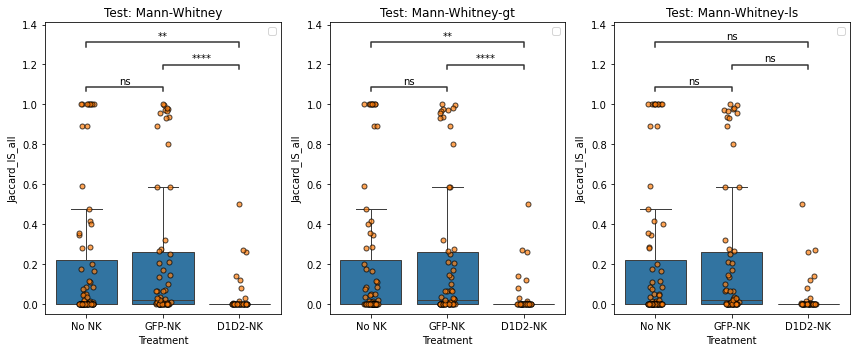

In [120]:
fig,axes = plt.subplots(1,3,figsize=[12,5])
axes = axes.flatten()
plot_Jaccard(Jaccard,'Jaccard_IS_all',axes)

plt.tight_layout()

plt.savefig('../figures/Jaccard_IS_all.png',dpi=300)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No NK vs. GFP-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:2.852e-01 U_stat=1.516e+03
GFP-NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:2.842e-01 U_stat=9.435e+02
No NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:7.479e-01 U_stat=8.115e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No NK vs. GFP-NK: Mann-Whitney-Wilcoxon test greater, P_val:8.589e-01 U_stat=1.516e+03
GFP-NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test greater, P_val:1.421e-01 U_stat=9.435e+02
No NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test greater, P_val:3.740e-01 U_stat=8.115e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 <

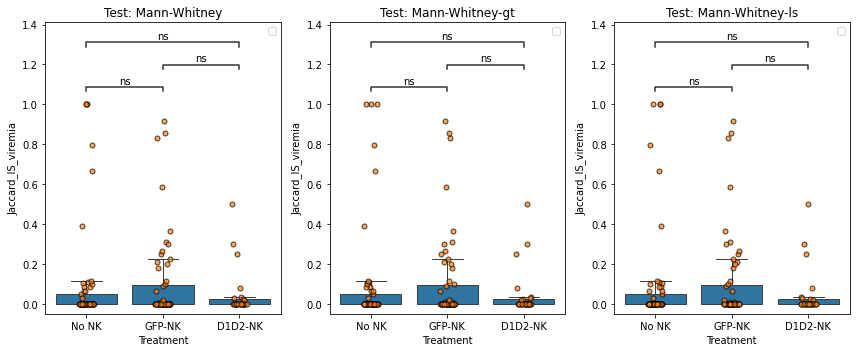

In [121]:
fig,axes = plt.subplots(1,3,figsize=[12,5])
axes = axes.flatten()
plot_Jaccard(Jaccard,'Jaccard_IS_viremia',axes)

plt.tight_layout()

plt.savefig('../figures/Jaccard_IS_viremia.png',dpi=300)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No NK vs. GFP-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:1.511e-01 U_stat=1.020e+03
GFP-NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:4.497e-01 U_stat=2.390e+02
No NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:9.053e-01 U_stat=2.330e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No NK vs. GFP-NK: Mann-Whitney-Wilcoxon test greater, P_val:7.557e-02 U_stat=1.020e+03
GFP-NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test greater, P_val:7.813e-01 U_stat=2.390e+02
No NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test greater, P_val:4.526e-01 U_stat=2.330e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 <

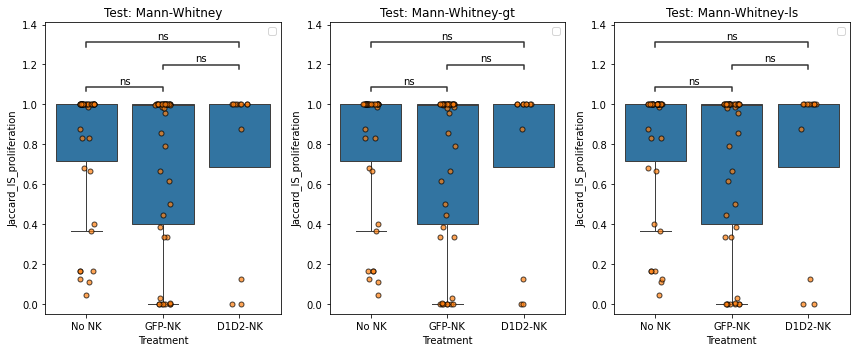

In [122]:
fig,axes = plt.subplots(1,3,figsize=[12,5])
axes = axes.flatten()
plot_Jaccard(Jaccard,'Jaccard_IS_proliferation',axes)

plt.tight_layout()

plt.savefig('../figures/Jaccard_IS_proliferation.png',dpi=300)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No NK vs. GFP-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:5.732e-01 U_stat=1.575e+03
GFP-NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:7.028e-03 U_stat=1.199e+03
No NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:3.652e-02 U_stat=1.383e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No NK vs. GFP-NK: Mann-Whitney-Wilcoxon test greater, P_val:7.155e-01 U_stat=1.575e+03
GFP-NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test greater, P_val:3.514e-03 U_stat=1.199e+03
No NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test greater, P_val:1.826e-02 U_stat=1.383e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 <

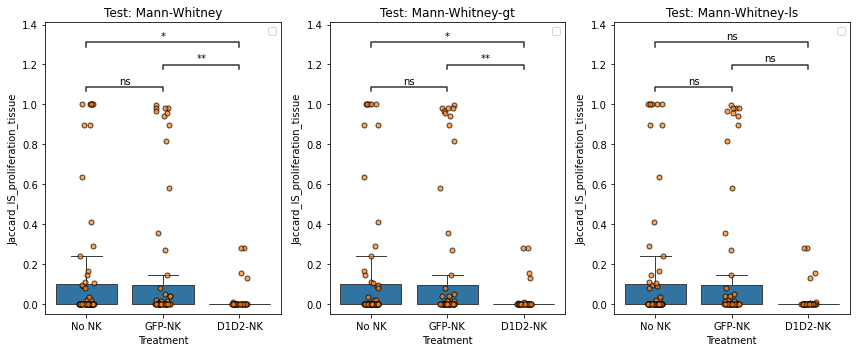

In [123]:
fig,axes = plt.subplots(1,3,figsize=[12,5])
axes = axes.flatten()
plot_Jaccard(Jaccard,'Jaccard_IS_proliferation_tissue',axes)

plt.tight_layout()

plt.savefig('../figures/Jaccard_IS_proliferation_tissue.png',dpi=300)

# DNA barcode Jaccard

In [124]:
perBC = pd.read_csv('../csvfiles/perBC_lite.csv')

reseeding_dict = perBC.groupby(['barcode','AnimalID']).count()[['site']].to_dict()
perBC.loc[:,'Reseeding'] = perIS.apply(lambda x: reseeding_dict['site'][(x['barcode'],x['AnimalID'])]>1,axis=1)

perBC['Reseeding_tissue'] = perBC['site']>1

In [125]:
perBC.to_csv('../csvfiles/perBC_lite_update110625.csv',index=False)

In [100]:
Jaccard_BC = get_Jaccard_df(perBC,'BC')
Jaccard_BC = Jaccard_BC.rename(columns = {'Jaccard':'Jaccard_BC_all'})

Jaccard_BC_viremia = get_Jaccard_df(perBC[perBC['Viremia']])
Jaccard_BC_viremia = Jaccard_BC_viremia.rename(columns = {'Jaccard':'Jaccard_BC_viremia'})
Jaccard_BC = pd.merge(Jaccard_BC,Jaccard_BC_viremia,left_on=['Treatment','AnimalID','organ1','organ2'],right_on=['Treatment','AnimalID','organ1','organ2'],how='outer')

Jaccard_BC_reseeding = get_Jaccard_df(perBC[perBC['Reseeding']])
Jaccard_BC_reseeding = Jaccard_BC_reseeding.rename(columns = {'Jaccard':'Jaccard_BC_reseeding'})
Jaccard_BC = pd.merge(Jaccard_BC,Jaccard_BC_reseeding,left_on=['Treatment','AnimalID','organ1','organ2'],right_on=['Treatment','AnimalID','organ1','organ2'],how='outer')

Jaccard_BC_reseeding_tissue = get_Jaccard_df(perBC[perBC['Reseeding_tissue']])
Jaccard_BC_reseeding_tissue = Jaccard_BC_reseeding_tissue.rename(columns = {'Jaccard':'Jaccard_BC_reseeding_tissue'})
Jaccard_BC = pd.merge(Jaccard_BC,Jaccard_BC_reseeding_tissue,left_on=['Treatment','AnimalID','organ1','organ2'],right_on=['Treatment','AnimalID','organ1','organ2'],how='outer')


In [101]:
Jaccard_BC.to_csv('../csvfiles/Jaccard_DNA_BC.csv',index=False)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No NK vs. GFP-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:5.069e-01 U_stat=2.203e+03
GFP-NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:2.975e-03 U_stat=1.668e+03
No NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:7.887e-03 U_stat=1.970e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No NK vs. GFP-NK: Mann-Whitney-Wilcoxon test greater, P_val:7.479e-01 U_stat=2.203e+03
GFP-NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test greater, P_val:1.488e-03 U_stat=1.668e+03
No NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test greater, P_val:3.944e-03 U_stat=1.970e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 <

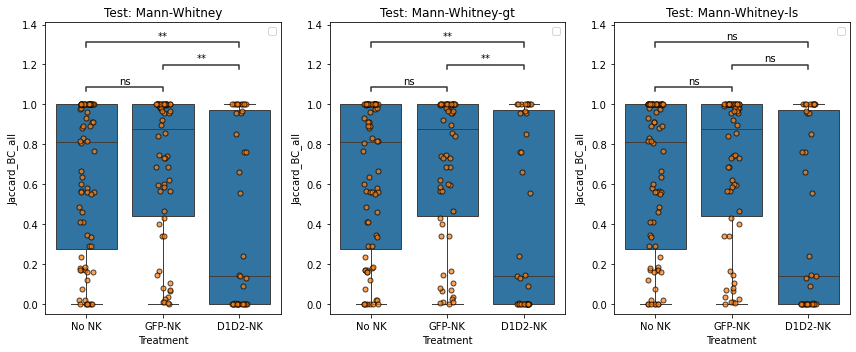

In [102]:
fig,axes = plt.subplots(1,3,figsize=[12,5])
axes = axes.flatten()
plot_Jaccard(Jaccard_BC,'Jaccard_BC_all',axes)

plt.tight_layout()

plt.savefig('../figures/Jaccard_BC_all.png',dpi=300)

In [103]:
Jaccard_BC

,Treatment,AnimalID,organ1,organ2,Jaccard_BC_all,Jaccard_BC_viremia,Jaccard_BC_reseeding,Jaccard_BC_reseeding_tissue
0,D1D2-NK,JCMMG32-#44,BM,LIV,0.000000,NaN,NaN,NaN
1,D1D2-NK,JCMMG32-#44,BM,SP,0.145492,0.000000,0.669202,0.515924
2,D1D2-NK,JCMMG32-#44,LIV,BM,0.000000,NaN,NaN,NaN
3,D1D2-NK,JCMMG32-#44,LIV,SP,0.000000,NaN,NaN,NaN
4,D1D2-NK,JCMMG32-#44,SP,BM,0.238202,0.000000,0.845938,0.083333
...,...,...,...,...,...,...,...,...
173,No NK,JMGA36-#8,BM,SP,0.549550,0.000000,0.019802,0.000000
174,No NK,JMGA36-#8,LIV,BM,0.000000,0.000000,0.035211,0.000000
175,No NK,JMGA36-#8,LIV,SP,1.000000,1.000000,1.000000,1.000000
176,No NK,JMGA36-#8,SP,BM,0.117647,0.000000,0.333333,0.000000


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No NK vs. GFP-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:1.779e-01 U_stat=1.858e+03
GFP-NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:2.333e-02 U_stat=9.800e+02
No NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:1.968e-03 U_stat=1.008e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No NK vs. GFP-NK: Mann-Whitney-Wilcoxon test greater, P_val:8.897e-02 U_stat=1.858e+03
GFP-NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test greater, P_val:1.166e-02 U_stat=9.800e+02
No NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test greater, P_val:9.838e-04 U_stat=1.008e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 <

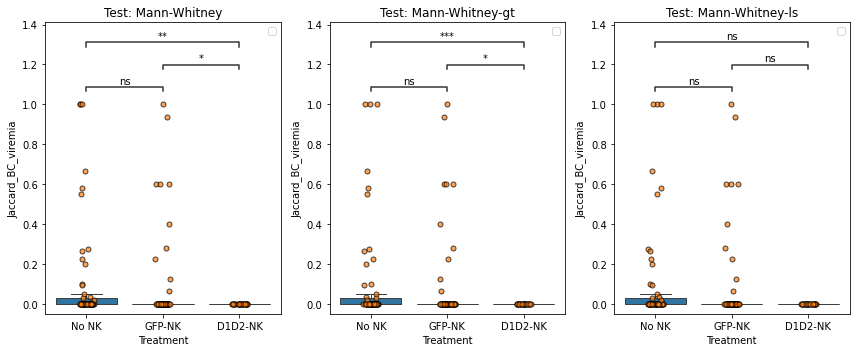

In [104]:
fig,axes = plt.subplots(1,3,figsize=[12,5])
axes = axes.flatten()
plot_Jaccard(Jaccard_BC,'Jaccard_BC_viremia',axes)

plt.tight_layout()

plt.savefig('../figures/Jaccard_BC_viremia.png',dpi=300)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No NK vs. GFP-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:4.700e-01 U_stat=1.934e+03
GFP-NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:3.129e-02 U_stat=8.125e+02
No NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:4.913e-03 U_stat=8.215e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No NK vs. GFP-NK: Mann-Whitney-Wilcoxon test greater, P_val:2.350e-01 U_stat=1.934e+03
GFP-NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test greater, P_val:1.564e-02 U_stat=8.125e+02
No NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test greater, P_val:2.456e-03 U_stat=8.215e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 <

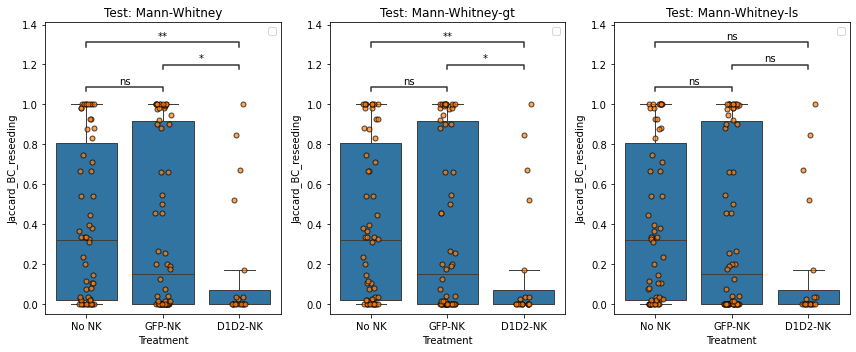

In [105]:
fig,axes = plt.subplots(1,3,figsize=[12,5])
axes = axes.flatten()
plot_Jaccard(Jaccard_BC,'Jaccard_BC_reseeding',axes)

plt.tight_layout()

plt.savefig('../figures/Jaccard_BC_reseeding.png',dpi=300)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No NK vs. GFP-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:5.510e-01 U_stat=1.588e+03
GFP-NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:1.676e-01 U_stat=9.065e+02
No NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test two-sided, P_val:4.012e-01 U_stat=9.140e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No NK vs. GFP-NK: Mann-Whitney-Wilcoxon test greater, P_val:7.267e-01 U_stat=1.588e+03
GFP-NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test greater, P_val:8.380e-02 U_stat=9.065e+02
No NK vs. D1D2-NK: Mann-Whitney-Wilcoxon test greater, P_val:2.006e-01 U_stat=9.140e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 <

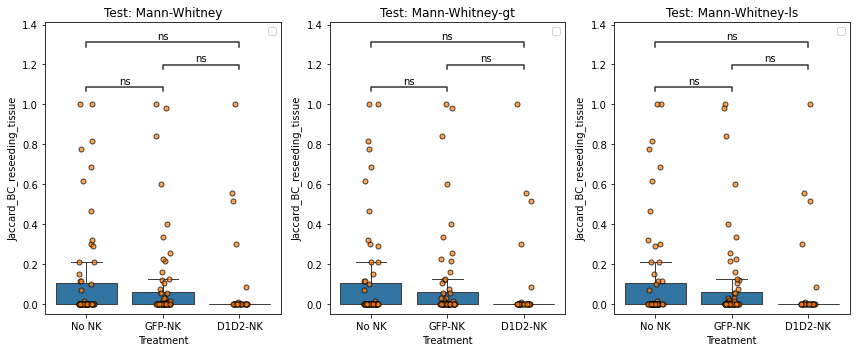

In [106]:
fig,axes = plt.subplots(1,3,figsize=[12,5])
axes = axes.flatten()
plot_Jaccard(Jaccard_BC,'Jaccard_BC_reseeding_tissue',axes)

plt.tight_layout()

plt.savefig('../figures/Jaccard_BC_reseeding_tissue.png',dpi=300)